In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

#from scipy.interpolate import spline
# jupyter nbconvert xxx.ipynb --no-input

In [2]:
figNameSvg = 'fig/v11nR07A_Defe_ctiveLifetime.svg'
figNamePng = 'fig/v11nR07A_Defe_ctiveLifetime.png'

Ts = 501
outputdiv = 100000
beads = 13
segments = beads-1
bondlength = 0.25

In [5]:
columns = ['ts','im','mt','c','xc','yc','zc','xm','ym','zm','fx','fy','fz'] 
# ts = timestep, im = motor index, mt = motor type (active = 1, defective = 2)
# c = contact  state, xc|yc|zc = binding motor head position, xm|ym|zm = binding motor root position 
# fx|fy|fz = xyz motor force at the root??
ms = pd.read_csv('dataDt1s5/MotorStates_A001_R070_273s5kd0.txt', names=columns, delim_whitespace=True)
conf = pd.read_csv('dataDt1s5/Conformation_A001_R07_273s5.txt', names=['ts','x','y','z'], delim_whitespace=True)

In [6]:
# Separate active motor and defective binding motors.
ms_act = ms[ms.mt == 1]
ms_act = ms_act.reset_index(drop=True)
ms_def = ms[ms.mt == 2]
ms_def = ms_def.reset_index(drop=True)

In [7]:
#act_seg12 = ms_act[ms_act.c.between(1,2)]

In [8]:
# binding motor data for active motors binding in segment 1-2 => act_seg[0], ...
act_seg = [[] for _ in range(segments)]
def_seg = [[] for _ in range(segments)]

for i in range(segments):
    act_seg[i] = ms_act[ms_act.c.between(i+1,i+2)]
    def_seg[i] = ms_def[ms_def.c.between(i+1,i+2)]

In [9]:
#len(act_seg[11][act_seg[11].ts == 27000000]['c'])

In [10]:
m1lyf_m = []; m2lyf_m = []; m1lyf_d = []; m2lyf_d = []

for seg in range(segments):
    act_xy = np.around( act_seg[seg][['im','c','xm','ym']], 6).values.tolist()
    def_xy = np.around( def_seg[seg][['im','c','xm','ym']], 6).values.tolist()
    #=====================================
    #=====================================
    m1lyf = {}
    for i in act_xy:
        if str(i) not in m1lyf:
            m1lyf[str(i)]=0
        else:
            m1lyf[str(i)] += 1
    #=========================================================        
    m2lyf = {}
    for i in def_xy:
        if str(i) not in m2lyf:
            m2lyf[str(i)]=0
        else:
            m2lyf[str(i)] += 1
    #=====================================
    #=====================================
    m1lyftym = np.fromiter(m1lyf.values(), dtype=int) # pick dictionary values
    m1lyf_Ag = pd.DataFrame({'life':m1lyftym}) # make pandas dataframe
    # Make a nice list from the dictionary keys.
    m1lyf_lst = []
    for i in list(m1lyf.keys()):
        m1lyf_lst.append(literal_eval(i))
    m1lyf_lst = np.array(m1lyf_lst) # nice list
    #=========================================================   
    m2lyftym = np.fromiter(m2lyf.values(), dtype=int) # pick dictionary values
    m2lyf_Ag = pd.DataFrame({'life':m2lyftym}) # make pandas dataframe
    # Make a nice list from the dictionary keys.
    m2lyf_lst = []
    for i in list(m2lyf.keys()):
        m2lyf_lst.append(literal_eval(i))
    m2lyf_lst = np.array(m2lyf_lst) # nice list    
    #=====================================
    #=====================================
    m1Ag_mtr = pd.DataFrame({'xp':m1lyf_lst[:,2], 'yp':m1lyf_lst[:,3]}) # pandas dataframe of aggressive binding m1
    m1Aglyf = pd.concat([m1Ag_mtr,m1lyf_Ag], axis=1)
    m1Aglyf = m1Aglyf[m1Aglyf.life > 0]
    #=========================================================   
    m2Ag_mtr = pd.DataFrame({'xp':m2lyf_lst[:,2], 'yp':m2lyf_lst[:,3]}) # pandas dataframe of aggressive binding m1
    m2Aglyf = pd.concat([m2Ag_mtr,m2lyf_Ag], axis=1)
    m2Aglyf = m2Aglyf[m2Aglyf.life > 0]
    #m2Aglyf.to_csv('def_with_lyf.csv')    
    #=====================================
    #=====================================
    m1lyf_m.append(np.mean(0.01*m1Aglyf['life']))
    m1lyf_d.append(np.std(0.01*m1Aglyf['life']))
    m2lyf_m.append(np.mean(0.01*m2Aglyf['life']))  
    m2lyf_d.append(np.std(0.01*m2Aglyf['life'])) 

In [11]:
act_bm_seg = [[] for _ in range(segments)]
def_bm_seg = [[] for _ in range(segments)]

for i in np.arange(0,Ts*outputdiv,outputdiv):
    for j in range(segments):
        act_bm = len(act_seg[j][act_seg[j].ts == i]['c'])
        act_bm_seg[j].append(act_bm)
        def_bm = len(def_seg[j][def_seg[j].ts == i]['c'])
        def_bm_seg[j].append(def_bm)

In [12]:
av_act_bm_seg = []; av_def_bm_seg = []
dv_act_bm_seg = []; dv_def_bm_seg = []

for i in range(segments):
    av_act = np.array(act_bm_seg[i]).mean()
    dv_act = np.array(act_bm_seg[i]).std()
    av_act_bm_seg.append(av_act)
    dv_act_bm_seg.append(dv_act)
    av_def = np.array(def_bm_seg[i]).mean()
    dv_def = np.array(def_bm_seg[i]).std()
    av_def_bm_seg.append(av_def)
    dv_def_bm_seg.append(dv_def)

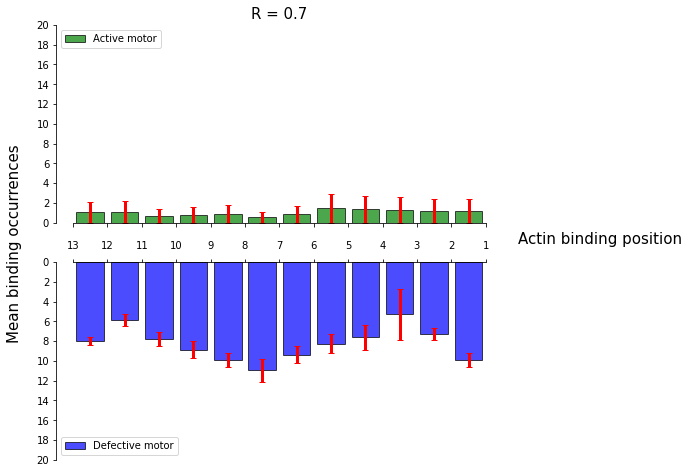

In [13]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#plt.subplots_adjust(hspace=0.15)

bins = np.arange(1.5,13.5)
ymax = 21; ystep = 2

ax.bar(bins,av_act_bm_seg, yerr=av_act_bm_seg, align='center', ecolor='red', error_kw=dict(lw=3,capsize=3,capthick=1),\
       facecolor='green', alpha=0.7, ec='black', label='Active motor')

ax.set_xticks(np.arange(1,14,1))
ax.set_yticks(np.arange(0,ymax,ystep))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(1,13)
ax.spines['left'].set_bounds(0,ymax-1)
ax.invert_xaxis()
ax.tick_params(axis='x', which='both', pad=15)
ax.legend(loc = 'upper left')
ax.set_title('R = 0.7', fontsize=15)
#======================================================

ax2.bar(bins,av_def_bm_seg, yerr=dv_def_bm_seg, align='center', ecolor='red', error_kw=dict(lw=3,capsize=3,capthick=1),\
        facecolor='blue', alpha=0.7, ec='black', label='Defective motor')

ax2.set_xticks(np.arange(1,14,1))
ax2.set_yticks(np.arange(0,ymax,ystep))
ax2.spines['bottom'].set_position('zero')
ax2.spines['bottom'].set_bounds(1,13)
ax2.spines['left'].set_bounds(0,ymax-1)
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.tick_params(axis='x', direction='in')#, length=6, width=2, colors='r',grid_color='r', grid_alpha=0.5)
ax2.set_xticklabels([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc = 'lower left')

fig.text(1.07, 0.5, 'Actin binding position', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Mean binding occurrences', va='center', rotation='vertical', fontsize=15)

#plt.savefig('fig5/motors_MNpos5s133R95.svg', fmt='.svg', dpi=1200, bbox_inches='tight')
#plt.savefig('fig5/motors_MNpos5s133R95.png', fmt='.png', dpi=1200, bbox_inches='tight')

plt.show()

In [14]:
idx_act = 0; ts_act = []
idx_def = 0; ts_def = []

act_xy = np.around( ms_act[['im','c','xm','ym']], 6).values.tolist()
def_xy = np.around( ms_def[['im','c','xm','ym']], 6).values.tolist()
#=====================================
#=====================================
m1lyf = {}
for i in act_xy:
    if str(i) not in m1lyf:
        m1lyf[str(i)]=0
        ts_act.append(ms_act['ts'].iloc[idx_act])
    else:
        m1lyf[str(i)] += 1
    idx_act+=1
ts_act = np.array(ts_act)
#=========================================================        
m2lyf = {}
for i in def_xy:
    if str(i) not in m2lyf:
        m2lyf[str(i)]=0
        ts_def.append(ms_def['ts'].iloc[idx_def])
    else:
        m2lyf[str(i)] += 1
    idx_def+=1
ts_def = np.array(ts_def)
#=====================================
#=====================================
m1lyftym = np.fromiter(m1lyf.values(), dtype=int) # pick dictionary values
m1lyf_Ag = pd.DataFrame({'life':m1lyftym}) # make pandas dataframe
# Make a nice list from the dictionary keys.
m1lyf_lst = [] # NB: to get real life, *0.01 sec.
for i in list(m1lyf.keys()):
    m1lyf_lst.append(literal_eval(i))
m1lyf_lst = np.array(m1lyf_lst) # nice list
#=========================================================   
m2lyftym = np.fromiter(m2lyf.values(), dtype=int) # pick dictionary values
m2lyf_Ag = pd.DataFrame({'life':m2lyftym}) # make pandas dataframe
# Make a nice list from the dictionary keys.
m2lyf_lst = []
for i in list(m2lyf.keys()):
    m2lyf_lst.append(literal_eval(i))
m2lyf_lst = np.array(m2lyf_lst) # nice list    
#=====================================
#=====================================
m1Ag_mtr = pd.DataFrame({'ts':ts_act,'im':m1lyf_lst[:,0],'c':m1lyf_lst[:,1],'xm':m1lyf_lst[:,2], 'ym':m1lyf_lst[:,3]}) # pandas dataframe of aggressive binding m1
m1Aglyf = pd.concat([m1Ag_mtr,m1lyf_Ag], axis=1)
m1Aglyf = m1Aglyf[m1Aglyf.life >= 0] 
m1Aglyf = m1Aglyf[m1Aglyf.life >= m1Aglyf['life'].mean()] # mean lifetime for binding motors during entire simulation
#=========================================================   
m2Ag_mtr = pd.DataFrame({'ts':ts_def,'im':m2lyf_lst[:,0],'c':m2lyf_lst[:,1],'xm':m2lyf_lst[:,2], 'ym':m2lyf_lst[:,3]}) # pandas dataframe of aggressive binding m1
m2Aglyf = pd.concat([m2Ag_mtr,m2lyf_Ag], axis=1)
m2Aglyf = m2Aglyf[m2Aglyf.life >= 0]
m2Aglyf = m2Aglyf[m2Aglyf.life >= m2Aglyf['life'].mean()]

##m2Aglyf.to_csv('def_with_lyf.csv')    
#=====================================
#=====================================
#m1lyf_m.append(np.mean(0.01*m1Aglyf['life']))
#m1lyf_d.append(np.std(0.01*m1Aglyf['life']))
#m2lyf_m.append(np.mean(0.01*m2Aglyf['life']))  
#m2lyf_d.append(np.std(0.01*m2Aglyf['life'])) 

In [15]:
# binding motor data for active motors binding in segment 1-2 => act_seg[0], ...
act_seg = [[] for _ in range(segments)]
def_seg = [[] for _ in range(segments)]

for i in range(segments):
    act_seg[i] = m1Aglyf[m1Aglyf.c.between(i+1,i+2)]
    def_seg[i] = m2Aglyf[m2Aglyf.c.between(i+1,i+2)]

In [16]:
act_bm_seg = [[] for _ in range(segments)]
def_bm_seg = [[] for _ in range(segments)]

for i in np.arange(0,Ts*outputdiv,outputdiv):
    for j in range(segments):
        act_bm = len(act_seg[j][act_seg[j].ts == i]['c'])
        if act_bm > 0:
            act_bm_seg[j].append(act_bm)
        def_bm = len(def_seg[j][def_seg[j].ts == i]['c'])
        if def_bm > 0:
            def_bm_seg[j].append(def_bm)

In [17]:
def_bm_seg[0]

[2, 3, 1, 1, 2, 1]

In [18]:
av_act_bm_seg = []; av_def_bm_seg = []
dv_act_bm_seg = []; dv_def_bm_seg = []

for i in range(segments):
    av_act = np.array(act_bm_seg[i]).mean()
    dv_act = np.array(act_bm_seg[i]).std()
    av_act_bm_seg.append(av_act)
    dv_act_bm_seg.append(dv_act)
    av_def = np.array(def_bm_seg[i]).mean()
    dv_def = np.array(def_bm_seg[i]).std()
    av_def_bm_seg.append(av_def)
    dv_def_bm_seg.append(dv_def)

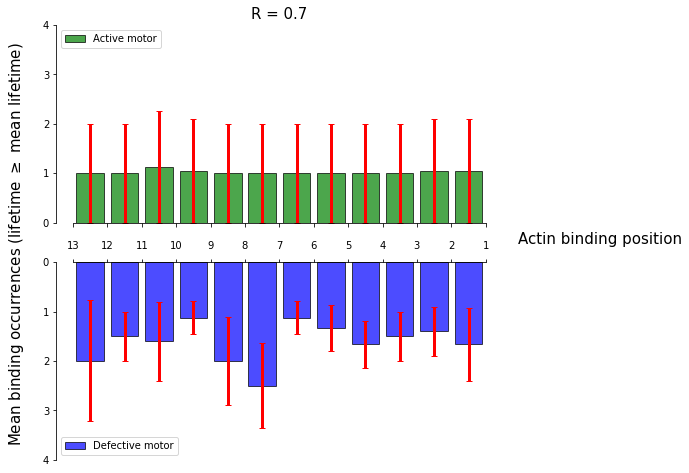

In [19]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#plt.subplots_adjust(hspace=0.15)

bins = np.arange(1.5,13.5)
ymax = 5; ystep = 1

ax.bar(bins,av_act_bm_seg, yerr=av_act_bm_seg, align='center', ecolor='red', error_kw=dict(lw=3,capsize=3,capthick=1),\
       facecolor='green', alpha=0.7, ec='black', label='Active motor')

ax.set_xticks(np.arange(1,14,1))
ax.set_yticks(np.arange(0,ymax,ystep))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(1,13)
ax.spines['left'].set_bounds(0,ymax-1)
ax.invert_xaxis()
ax.tick_params(axis='x', which='both', pad=15)
ax.legend(loc = 'upper left')
ax.set_title('R = 0.7', fontsize=15)
#======================================================

ax2.bar(bins,av_def_bm_seg, yerr=dv_def_bm_seg, align='center', ecolor='red', error_kw=dict(lw=3,capsize=3,capthick=1),\
        facecolor='blue', alpha=0.7, ec='black', label='Defective motor')

ax2.set_xticks(np.arange(1,14,1))
ax2.set_yticks(np.arange(0,ymax,ystep))
ax2.spines['bottom'].set_position('zero')
ax2.spines['bottom'].set_bounds(1,13)
ax2.spines['left'].set_bounds(0,ymax-1)
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.tick_params(axis='x', direction='in')#, length=6, width=2, colors='r',grid_color='r', grid_alpha=0.5)
ax2.set_xticklabels([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc = 'lower left')

fig.text(1.07, 0.5, 'Actin binding position', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Mean binding occurrences (lifetime $\geq$ mean lifetime)', va='center', rotation='vertical', fontsize=15)

#plt.savefig('fig5/motors_MNpos5s133R95.svg', fmt='.svg', dpi=1200, bbox_inches='tight')
#plt.savefig('fig5/motors_MNpos5s133R95.png', fmt='.png', dpi=1200, bbox_inches='tight')

plt.show()

$Effective\ segment\ force = active\ binding\ motors\ \sum{F_{act}} - defective\ binding\ motors\ \sum{F_{def}}$

$F_{xyz} = \sqrt{{F_x}^2 + {F_y}^2 + {F_z}^2}$

In [20]:
#xyz1 = conf[conf.ts == 100000].iloc[0].values[1:]

In [21]:
#xyz2 = conf[conf.ts == 100000].iloc[1].values[1:]

In [22]:
#np.sqrt( (xyz2[0]-xyz1[0])**2 + (xyz2[1]-xyz1[1])**2 + (xyz2[2]-xyz1[2])**2 )

In [23]:
#xyz_d = xyz2-xyz1
#np.sqrt(xyz_d.dot(xyz_d))

In [24]:
a = np.array([np.NaN, np.NaN])
b = np.array([np.NaN, 4, np.NaN, 3])
#np.NaN if np.all(a!=a) else np.nanmean(a)

In [25]:
#np.NaN if np.all(b!=b) else np.nansum(b)

In [26]:
#np.sum(b)

In [27]:
# binding motor data for active motors binding in segment 1-2 => act_seg[0], ...
act_seg = [[] for _ in range(segments)]
def_seg = [[] for _ in range(segments)]

for i in range(segments):
    act_seg[i] = ms_act[ms_act.c.between(i+1,i+2)]
    def_seg[i] = ms_def[ms_def.c.between(i+1,i+2)]

In [28]:
#tst = np.array([2.1, 1.6, 8.9])
#np.sqrt(tst[0]**2 + tst[1]**2 + tst[2]**2) == np.sqrt(tst.dot(tst)) # True

In [29]:
mag_seg = []; mag_ts_seg = []

for i in np.arange(0,Ts*outputdiv,outputdiv):
    for bead in range(segments):
        xyz1 = conf[conf.ts == i].iloc[bead].values[1:]
        xyz2 = conf[conf.ts == i].iloc[bead+1].values[1:]
        xyz_d = xyz2-xyz1
        mag_seg.append( np.sqrt(xyz_d.dot(xyz_d)) )
    mag_ts_seg.append(mag_seg)
    mag_seg = []

In [30]:
act_F_seg = [[] for _ in range(segments)]
def_F_seg = [[] for _ in range(segments)]
act_F_i = []; def_F_i = []
ts_count = 0
all_act_drag = []; all_def_drag = []

for i in np.arange(0,Ts*outputdiv,outputdiv):
    for j in range(segments):
        count = len(act_seg[j][act_seg[j].ts == i])
        for k in range(count):
            frc = np.array([act_seg[j][act_seg[j].ts == i]['fx'].iloc[k],\
                           act_seg[j][act_seg[j].ts == i]['fy'].iloc[k],\
                           act_seg[j][act_seg[j].ts == i]['fz'].iloc[k]])
            frc_i = np.sqrt(frc.dot(frc))
            drag = frc_i #*(mag_ts_seg[ts_count][j] / bondlength)
            all_act_drag.append(drag)
            if np.isfinite(drag) == False:
                print('act_nan: Ts %s, Seg %s, Count %s'%(i,j,k))
            if drag > 9.2:
                print('act-over-drag: drag: %s, Ts: %s, Seg: %s, Count: %s'%(round(drag,4),i,j,k))
            act_F_i.append(drag)
        for _ in act_F_i:
            if np.isfinite(_) == False:
                print(_)
        act_F_i = np.array(act_F_i)
        act_F_seg[j].append(np.NaN if np.all(act_F_i!=act_F_i) else np.nansum(act_F_i))
        act_F_i = []
    ts_count+=1
#=============================================================
ts_count = 0
for i in np.arange(0,Ts*outputdiv,outputdiv):
    for j in range(segments):
        count = len(def_seg[j][def_seg[j].ts == i])
        for k in range(count):
            frc = np.array([def_seg[j][def_seg[j].ts == i]['fx'].iloc[k],\
                           def_seg[j][def_seg[j].ts == i]['fy'].iloc[k],\
                           def_seg[j][def_seg[j].ts == i]['fz'].iloc[k]])
            frc_i = np.sqrt(frc.dot(frc))
            drag = frc_i #*(mag_ts_seg[ts_count][j] / bondlength)
            all_def_drag.append(drag)
            if np.isfinite(drag) == False:
                print('def_nan: Ts %s, Seg %s, Count %s'%(i,j,k))
            if drag > 9.2:
                print('def-over-drag: drag: %s, Ts: %s, Seg: %s, Count: %s'%(round(drag,4),i,j,k))
            def_F_i.append(drag)
        def_F_i = np.array(def_F_i)
        def_F_seg[j].append(np.NaN if np.all(def_F_i!=def_F_i) else np.nansum(def_F_i))
        def_F_i = []
    ts_count+=1

In [38]:
#plt.hist(all_def_drag, color='b', alpha=0.7)
#plt.hist(all_act_drag, color='g')
#plt.show()

In [32]:
av_act_bm_seg = []; av_def_bm_seg = []
dv_act_bm_seg = []; dv_def_bm_seg = []

for i in range(segments):
    av_act = np.array(act_F_seg[i])
    #dv_act = np.array(act_F_seg[i])
    av_act_bm_seg.append( np.NaN if np.all(av_act != av_act) else np.nanmean(av_act) )
    dv_act_bm_seg.append( np.NaN if np.all(av_act != av_act) else np.nanstd(av_act) )
    av_def = np.array(def_F_seg[i])
    #dv_def = np.array(def_F_seg[i]).std()
    av_def_bm_seg.append( np.NaN if np.all(av_def != av_def) else np.nanmean(av_def) )
    dv_def_bm_seg.append( np.NaN if np.all(av_def != av_def) else np.nanstd(av_def) )

In [33]:
eff_F_seg = [[] for _ in range(segments)]
eff_F_i = []

for i in np.arange(0,Ts,1): #Ts
    for j in range(segments): #segment
        eff_F_i = np.nansum([ act_F_seg[j][i], -1*def_F_seg[j][i] ])
        eff_F_seg[j].append(eff_F_i)  # np.sum(eff_F_i)

#=============================================================

In [34]:
Ef_m = []; Ef_d = []

for i in range(segments):
    Ef_m.append(np.nanmean(np.array(eff_F_seg[i])))
    Ef_d.append(np.nanstd(np.array(eff_F_seg[i])))

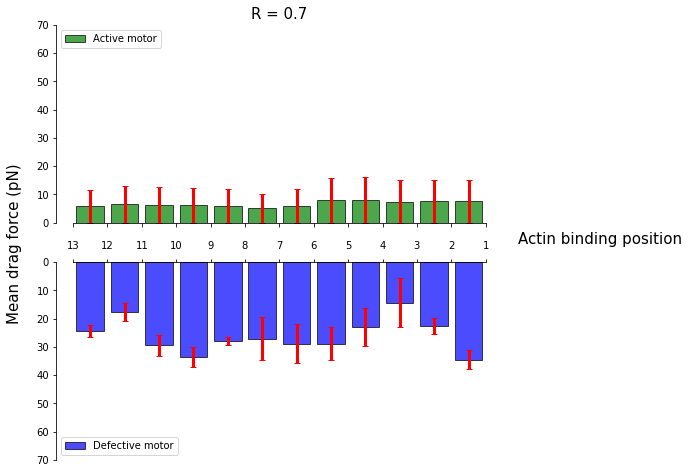

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#plt.subplots_adjust(hspace=0.15)

bins = np.arange(1.5,13.5)
ymax = 80; ystep = 10

ax.bar(bins,av_act_bm_seg, yerr=av_act_bm_seg, align='center', ecolor='red', error_kw=dict(lw=3,capsize=3,capthick=1),\
       facecolor='green', alpha=0.7, ec='black', label='Active motor')

ax.set_xticks(np.arange(1,14,1))
ax.set_yticks(np.arange(0,ymax,ystep))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(1,13)
#ax.spines['left'].set_bounds(0,ymax-1)
ax.invert_xaxis()
ax.tick_params(axis='x', which='both', pad=15)
ax.legend(loc = 'upper left')
ax.set_title('R = 0.7', fontsize=15)
#======================================================

ax2.bar(bins,av_def_bm_seg, yerr=dv_def_bm_seg, align='center', ecolor='red', error_kw=dict(lw=3,capsize=3,capthick=1),\
        facecolor='blue', alpha=0.7, ec='black', label='Defective motor')

ax2.set_xticks(np.arange(1,14,1))
ax2.set_yticks(np.arange(0,ymax,ystep))
ax2.spines['bottom'].set_position('zero')
ax2.spines['bottom'].set_bounds(1,13)
#ax2.spines['left'].set_bounds(0,ymax-1)
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.tick_params(axis='x', direction='in')#, length=6, width=2, colors='r',grid_color='r', grid_alpha=0.5)
ax2.set_xticklabels([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc = 'lower left')

fig.text(1.07, 0.5, 'Actin binding position', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Mean drag force (pN)', va='center', rotation='vertical', fontsize=15)

#plt.savefig('fig5/motors_MNpos5s133R95.svg', fmt='.svg', dpi=1200, bbox_inches='tight')
#plt.savefig('fig/R07_dragForce.png', format='png', dpi=500, bbox_inches='tight')

plt.show()

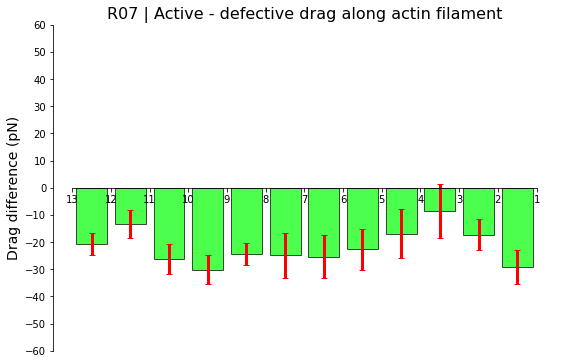

In [36]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

ax.bar(bins,Ef_m, yerr=Ef_d, align='center', ecolor='red', error_kw=dict(lw=3,capsize=3,capthick=1),\
       facecolor='lime', ec='black', alpha=0.7, label='Effective force')
ax.spines['bottom'].set_position('zero')
ax.invert_xaxis()
ax.set_xticks(np.arange(1,14,1))
ax.set_yticks(np.arange(-60,61,10))
ax.spines['bottom'].set_bounds(1,13)
ax.spines['left'].set_bounds(-60,60)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('R07 | Active - defective drag along actin filament', fontsize=16)
ax.set_ylabel('Drag difference (pN)', fontsize=14)

plt.show()

In [39]:
!jupyter nbconvert V11nR07dt1s5_contact_force_kd0.ipynb --no-input --to html

[NbConvertApp] Converting notebook V11nR07dt1s5_contact_force_kd0.ipynb to html
[NbConvertApp] Writing 661121 bytes to V11nR07dt1s5_contact_force_kd0.html
